In [ ]:
!pip install numpy-financial
import numpy as np
import numpy_financial as npf
import pandas as pd
from google.colab import files
from scipy.optimize import brentq



# 加载上传的数据集
uploaded = files.upload()
electricity_prices_df = pd.read_csv('processed_simulated_paths_no_year.csv')  # 每小时电价
capacity_factors_df = pd.read_csv('Capacity_Data_by_Hour_and_Year.csv')  # 每小时容量因子



Saving Capacity_Data_by_Hour_and_Year.csv to Capacity_Data_by_Hour_and_Year (1).csv
Saving processed_simulated_paths_no_year.csv to processed_simulated_paths_no_year (1).csv


25th Percentile: 66.14 GBP/MWh
50th Percentile (Median): 66.91 GBP/MWh
75th Percentile: 67.69 GBP/MWh


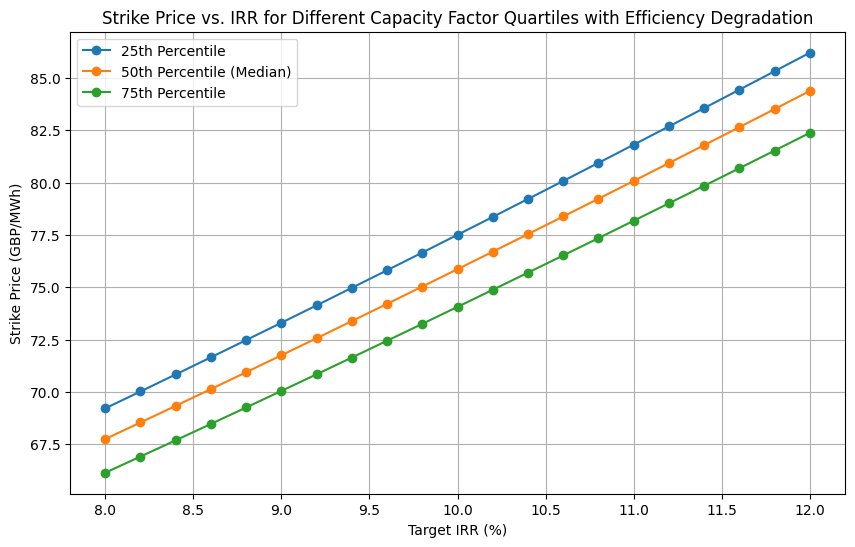

In [ ]:
import numpy as np
import numpy_financial as npf
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import brentq

# 项目已知参数
installed_capacity_mw = 800  # 800 MW
project_lifetime_years = 25  # 项目年限25年
capex_per_kw = 2500  # £2,500 每千瓦 (kW)
opex_per_mw_per_year = 100000  # 每年运营支出
discount_rate = 0.08  # 折现率 8%
grid_connection_cost_per_km = 750000  # 电网接入成本每公里£750,000
grid_connection_distance_km = 50  # 默认距离50公里
annual_degradation = 0.005  # 每年0.5%的效率降低

# 计算总CAPEX和每年的OPEX
total_capex = installed_capacity_mw * 1000 * capex_per_kw  # 总资本支出
annual_opex = installed_capacity_mw * opex_per_mw_per_year  # 每年运营支出
grid_connection_cost = grid_connection_cost_per_km * grid_connection_distance_km
total_capex += grid_connection_cost  # 将其包含在总CAPEX中

# 转换所有数值列，并填充空值为0
electricity_prices_df.iloc[:, 1:] = electricity_prices_df.iloc[:, 1:].apply(pd.to_numeric, errors='coerce').fillna(0)
capacity_factors_df.iloc[:, 1:] = capacity_factors_df.iloc[:, 1:].apply(pd.to_numeric, errors='coerce').fillna(0)

# 判断年份是否是闰年
def is_leap_year(year):
    year = int(year)
    return year % 4 == 0 and (year % 100 != 0 or year % 400 == 0)

# 计算年收入
def calculate_annual_revenue(electricity_prices, capacity_factors, strike_price, year):
    length = min(len(electricity_prices), len(capacity_factors))
    # 考虑年度效率降低
    efficiency_degradation = (1 - annual_degradation) ** year
    hourly_revenue = [strike_price * capacity_factors[i] * installed_capacity_mw * efficiency_degradation for i in range(length)]
    annual_revenue = np.sum(hourly_revenue)
    return annual_revenue

# 模拟25年的收入并计算IRR
def simulate_25_years_irr(electricity_prices_df, capacity_factors, total_capex, annual_opex, strike_price):
    yearly_cash_flows = []
    for year in range(project_lifetime_years):
        # 每年随机选择一个电价路径
        random_path = np.random.choice(electricity_prices_df.columns[1:])

        # 获取该路径的电价
        selected_electricity_prices = electricity_prices_df[random_path].values

        # 计算该年的收入
        annual_revenue = calculate_annual_revenue(selected_electricity_prices, capacity_factors, strike_price, year + 1)

        # 计算该年的现金流
        yearly_cash_flows.append(annual_revenue - annual_opex)

    # 计算IRR
    cash_flows = [-total_capex] + yearly_cash_flows
    irr = npf.irr(cash_flows)
    return irr

# 反向求解罢工价
def find_strike_price(electricity_prices_df, capacity_factors, total_capex, annual_opex, target_irr):
    def objective(sp):
        irr = simulate_25_years_irr(electricity_prices_df, capacity_factors, total_capex, annual_opex, sp)
        if np.isnan(irr) or irr == float('inf') or irr == float('-inf'):
            return -100  # 避免NaN或无效结果
        return irr - target_irr

    lower_bound = 1  # GBP/MWh
    upper_bound = 500  # GBP/MWh

    # 确保搜索区间内的函数值有不同符号
    try:
        f_a = objective(lower_bound)
        f_b = objective(upper_bound)
        if f_a * f_b > 0:
            print(f"Objective function does not have different signs at the endpoints. f(1)={f_a}, f(500)={f_b}")
            return None
        strike_price_solution = brentq(objective, lower_bound, upper_bound)  # 搜索罢工价的区间
    except ValueError as e:
        print(f"Error in finding strike price: {e}")
        return None

    return strike_price_solution

# 计算每一年平均容量因子并存储在列表中
avg_capacity_factors = []

for year in capacity_factors_df.columns[1:]:  # 跳过日期列
    capacity_factors = capacity_factors_df[year].values

    # 检查并处理闰年
    if is_leap_year(year):
        capacity_factors = capacity_factors[:8784]  # 保留8784小时的数据
    else:
        capacity_factors = capacity_factors[:8760]  # 保留8760小时的数据

    # 计算该年的平均容量因子
    average_capacity_factor = np.mean(capacity_factors)

    # 将每年的平均容量因子及其年份存储到列表中
    avg_capacity_factors.append((average_capacity_factor, year))

# 按平均容量因子排序
avg_capacity_factors.sort()

# 计算四分位数
quartiles = [0.25, 0.5, 0.75]
quartile_indices = [int(len(avg_capacity_factors) * q) for q in quartiles]
quartile_years = [avg_capacity_factors[i][1] for i in quartile_indices]
quartile_labels = ['25th Percentile', '50th Percentile (Median)', '75th Percentile']

# 计算不同IRR下的罢工价并绘制曲线
target_irrs = np.arange(0.08, 0.12 + 0.002, 0.002)  # 从8%到12%，步长为0.2%
plt.figure(figsize=(10, 6))

for year, label in zip(quartile_years, quartile_labels):
    quartile_capacity_factors = capacity_factors_df[year].values
    strike_prices = []
    for target_irr in target_irrs:
        strike_price = find_strike_price(electricity_prices_df, quartile_capacity_factors, total_capex, annual_opex, target_irr)
        strike_prices.append(strike_price)

    # 绘制曲线
    plt.plot(target_irrs * 100, strike_prices, marker='o', linestyle='-', label=label)

# 输出结果并显示曲线
for label, sp in zip(quartile_labels, strike_prices):
    print(f"{label}: {sp:.2f} GBP/MWh")

plt.title('Strike Price vs. IRR for Different Capacity Factor Quartiles with Efficiency Degradation')
plt.xlabel('Target IRR (%)')
plt.ylabel('Strike Price (GBP/MWh)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Create a DataFrame to store strike price data
strike_price_data = {
    'Target IRR (%)': target_irrs * 100
}

for year, label in zip(quartile_years, quartile_labels):
    quartile_capacity_factors = capacity_factors_df[year].values
    strike_prices = []
    for target_irr in target_irrs:
        strike_price = find_strike_price(electricity_prices_df, quartile_capacity_factors, total_capex, annual_opex, target_irr)
        strike_prices.append(strike_price)

    strike_price_data[label] = strike_prices

# Create DataFrame and save to CSV
strike_price_df = pd.DataFrame(strike_price_data)
csv_filename = 'strike_price_vs_irr.csv'
strike_price_df.to_csv(csv_filename, index=False)

print(f"Data has been saved to '{csv_filename}'")

from google.colab import files
files.download(csv_filename)


Data has been saved to 'strike_price_vs_irr.csv'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>